In [1]:
# Standard library imports
import warnings

# Third-party imports for data manipulation and analysis
import pandas as pd
import numpy as np

# Third-party imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party imports for machine learning and data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Third-party imports for deep learning
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.callbacks import ReduceLROnPlateau

# Filter warnings
warnings.filterwarnings('ignore')

2024-07-31 16:46:35.048324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!ls

CNN CM.png
CNN_Test_Predictions.csv
Digit_Recognizer_Kaggel_Competition.ipynb
KNN CM.png
KNN_Test_Predictiond.csv
Resampling copy.png
Resampling.png
digit-recognizer
digit-recognizer.zip
label_distribution.png
sample_submission.csv
sub.png
test.csv
train.csv


In [5]:
train_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

# EAD

In [6]:
print(train_data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [7]:
print(test_data.head())

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   

In [8]:
print(train_data.isnull().sum())

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64


In [9]:
print(test_data.isnull().sum())

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


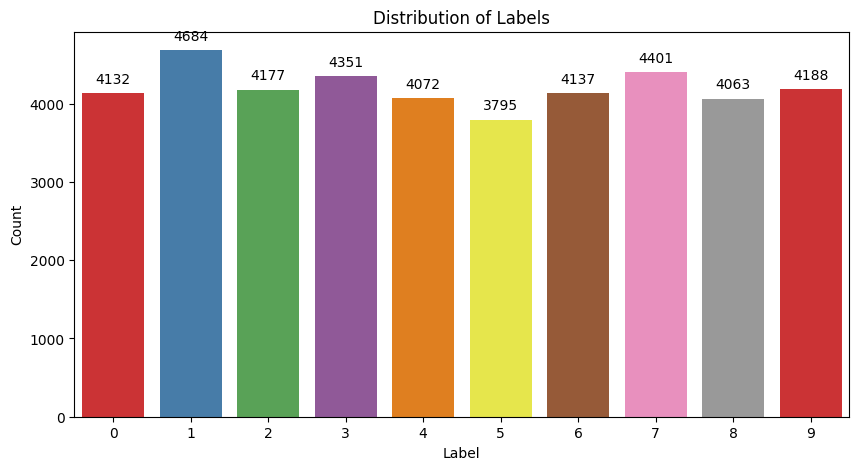

In [10]:

train_data['label'] = train_data['label'].astype('category')

plt.figure(figsize = (10,5))
ax = sns.countplot(x = 'label', data = train_data, palette = 'Set1')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.title('Distribution of Labels')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')
plt.show()

The data based on the label bar plot shows imbalance in these digits distribution

Handling data imbalance on the train set using oversampling method

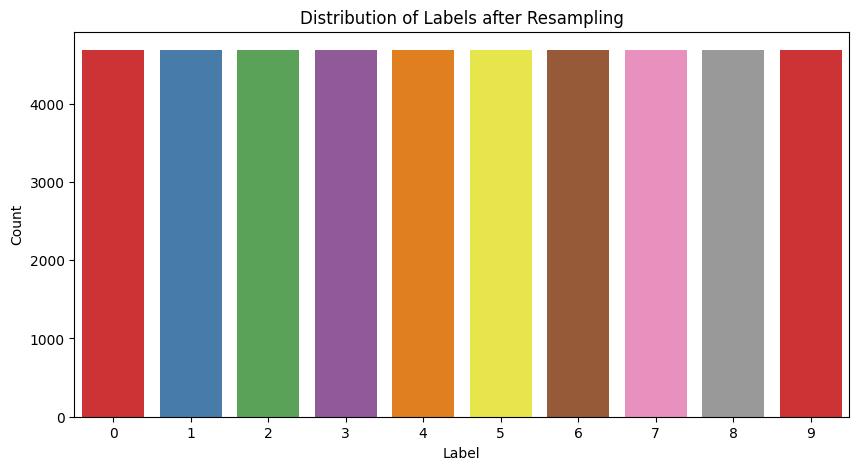

In [11]:
X_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]
X_test = test_data.iloc[:, 0:]

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

y_resampled_df = pd.DataFrame(y_resampled, columns=['label'])
y_resampled_df['label'] = y_resampled_df['label'].astype('category')

plt.figure(figsize = (10,5))
ax = sns.countplot(x = 'label', data = y_resampled_df, palette = 'Set1')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.title('Distribution of Labels after Resampling')
plt.show()

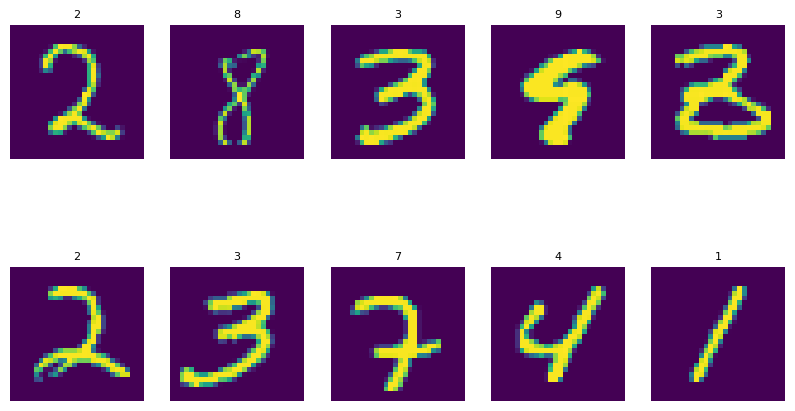

In [12]:
# Visualize image of the train set

W_grid = 5
L_grid = 2

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10, 6))

axes = axes.ravel()
n_train = len(train_data)

for i in np.arange(0, W_grid * L_grid):
  index = np.random.randint(0, n_train)
  axes[i].imshow(train_data.iloc[index, 1:].values.reshape((28,28)) )
  axes[i].set_title(train_data.iloc[index, 0], fontsize = 8)
  axes[i].axis('off')

plt.subplots_adjust(hspace = 0.1)
plt.show()

In [13]:
# Splitting the data

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

# Data Preprocessing for K-Nearest Neighbors (KNN)

In [14]:
# Scaling the data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# KNN Model

In [15]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

KNN_model.fit(X_train_scaled, y_train)

KNN_y_pre_val = KNN_model.predict(X_val_scaled)

KNN_accuracy = accuracy_score(y_val, KNN_y_pre_val)
print(f'KNN Accuracy on validation set: {KNN_accuracy}')

print(classification_report(y_val, KNN_y_pre_val))

KNN Accuracy on validation set: 0.9447053800170794
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       963
           1       0.97      0.99      0.98       949
           2       0.96      0.93      0.95       952
           3       0.90      0.94      0.92       913
           4       0.96      0.93      0.94       938
           5       0.94      0.93      0.94       925
           6       0.95      0.98      0.97       917
           7       0.95      0.93      0.94       966
           8       0.96      0.90      0.93       944
           9       0.90      0.92      0.91       901

    accuracy                           0.94      9368
   macro avg       0.94      0.94      0.94      9368
weighted avg       0.95      0.94      0.94      9368



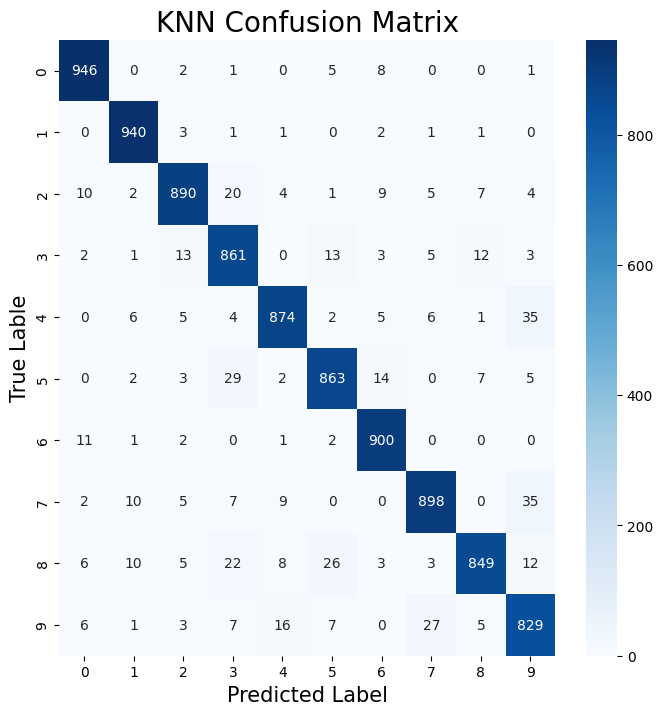

In [16]:
# Confusion Matrix 

KNN_cm = confusion_matrix(y_val, KNN_y_pre_val)

plt.figure(figsize = (8,8))
sns.heatmap(KNN_cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("KNN Confusion Matrix", fontsize = 20)
plt.ylabel('True Lable', fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15)
plt.show()

In [17]:
# Make predictions on the scaled test data

KNN_test_predictions = KNN_model.predict(X_test_scaled)

# Data Preprocessing for Convolutional Neural Networks Model (CNN)

In [18]:
# Reshape data

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)

# Normalize data

X_train = X_train / 255
X_val = X_val /  255

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train)

X_train shape: (37472, 28, 28, 1)
X_val shape: (9368, 28, 28, 1)
y_train shape: (37472, 10)
y_val shape: (9368, 10)
Type of X_train: float64
Type of y_train: float32


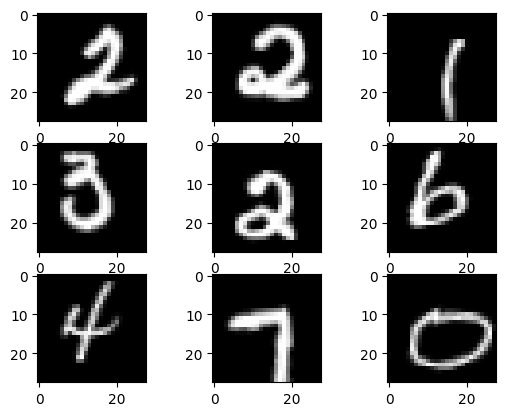

In [19]:
# Check shapes and types

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("Type of X_train:", X_train.dtype)
print("Type of y_train:", y_train.dtype)

# Visualize some augmented images

import matplotlib.pyplot as plt

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size = 9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap = plt.get_cmap('gray'))
    # Show the plot
    plt.show()
    break

# CNN Model

In [20]:
model = Sequential()

model.add(Input(shape=(28, 28, 1)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))

model.add(MaxPooling2D(2,2))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

learning_rate = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    min_lr = 0.00001,
    verbose = 1
)

2024-07-31 16:48:08.957183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

model.fit(X_train, y_train, validation_split = 0.2, epochs = 10)

predictions = model.predict(X_val)
pred_digits = np.argmax(predictions, axis = 1)

print(pred_digits)

Epoch 1/10
937/937 [==============================] - 97s 102ms/step - loss: 0.3403 - accuracy: 0.8953 - val_loss: 0.0843 - val_accuracy: 0.9756
Epoch 2/10
937/937 [==============================] - 100s 107ms/step - loss: 0.1084 - accuracy: 0.9701 - val_loss: 0.0679 - val_accuracy: 0.9800
Epoch 3/10
937/937 [==============================] - 101s 108ms/step - loss: 0.0701 - accuracy: 0.9809 - val_loss: 0.0513 - val_accuracy: 0.9867
Epoch 4/10
937/937 [==============================] - 70s 75ms/step - loss: 0.0552 - accuracy: 0.9842 - val_loss: 0.0533 - val_accuracy: 0.9875
Epoch 5/10
937/937 [==============================] - 71s 76ms/step - loss: 0.0414 - accuracy: 0.9878 - val_loss: 0.0717 - val_accuracy: 0.9863
Epoch 6/10
937/937 [==============================] - 71s 76ms/step - loss: 0.0341 - accuracy: 0.9902 - val_loss: 0.0658 - val_accuracy: 0.9872
Epoch 7/10
937/937 [==============================] - 75s 80ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0675 - val_accu

In [22]:
y_val_labels = np.argmax(y_val, axis = 1)

CNN_accuracy = accuracy_score(y_val_labels, pred_digits)

print("Validation Accuracy: ", CNN_accuracy)

Validation Accuracy:  0.9900725875320239


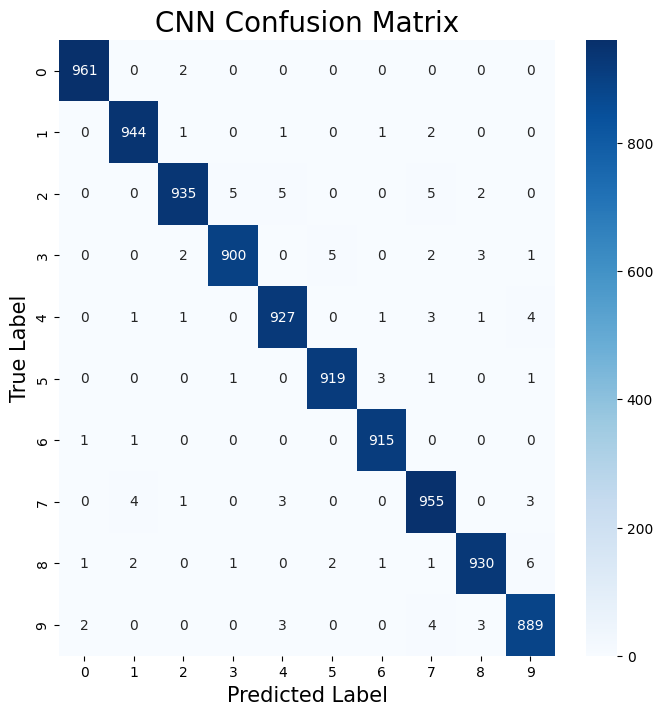

In [23]:
y_val_labels = np.argmax(y_val, axis=1)
predictions_labels = np.argmax(predictions, axis=1)

CNN_cm = confusion_matrix(y_val_labels, predictions_labels)

plt.figure(figsize = (8,8))
sns.heatmap(CNN_cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title("CNN Confusion Matrix", fontsize = 20)
plt.ylabel('True Label', fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15)

plt.show()

In [24]:
# Make predictions on the scaled test data
X_test_reshaped = X_test.to_numpy().reshape(-1, 28, 28, 1)

CNN_test_predictions = np.argmax(model.predict(X_test_reshaped), axis = -1)

875/875 [==============================] - 12s 13ms/step
